Now, we will perform an exploratory analysis of preprocessed data to uncover links between behavioral, self-reported and knowledge data. In particular, we will investigate **How student behavior during the trajectory (as a proxy for metacognitive engagement) relates to self-reported perceptions (e.g., effort, cognitive load, perceived difficulties), and whether these behaviors predict or moderate perceived effectiveness and knowledge gain.**

* Correlations or other predictive relationships between behavioral patterns and:
own effort, cognitive load, learning difficulty, effectiveness, test score
* Clusters or patterns of student behavior during the trajectory (e.g., low engagement vs. high engagement students).
* Does lower behavioral engagement correspond with lower perceived effectiveness and learning gain? This could indicate that students who do less (e.g., skip optional tasks, avoid hints) may also feel they learn less or actually gain less.


In [120]:
import pandas as pd

# Load episodes data
df_ep = pd.read_csv('agg_behavior_metrics.csv')
df_ep.set_index('student_id', inplace=True)

# Load knowledge gain data
df_kno = pd.read_csv('knowledge_clean.csv')
df_kno.set_index('student_id', inplace=True)

# Load self reported data
df_sel = pd.read_csv('self_report_clean.csv')
df_sel.set_index('student_id', inplace=True)

clean_df = pd.concat([df_ep,df_kno,df_sel], join='inner', axis=1)

# Correlation analysis

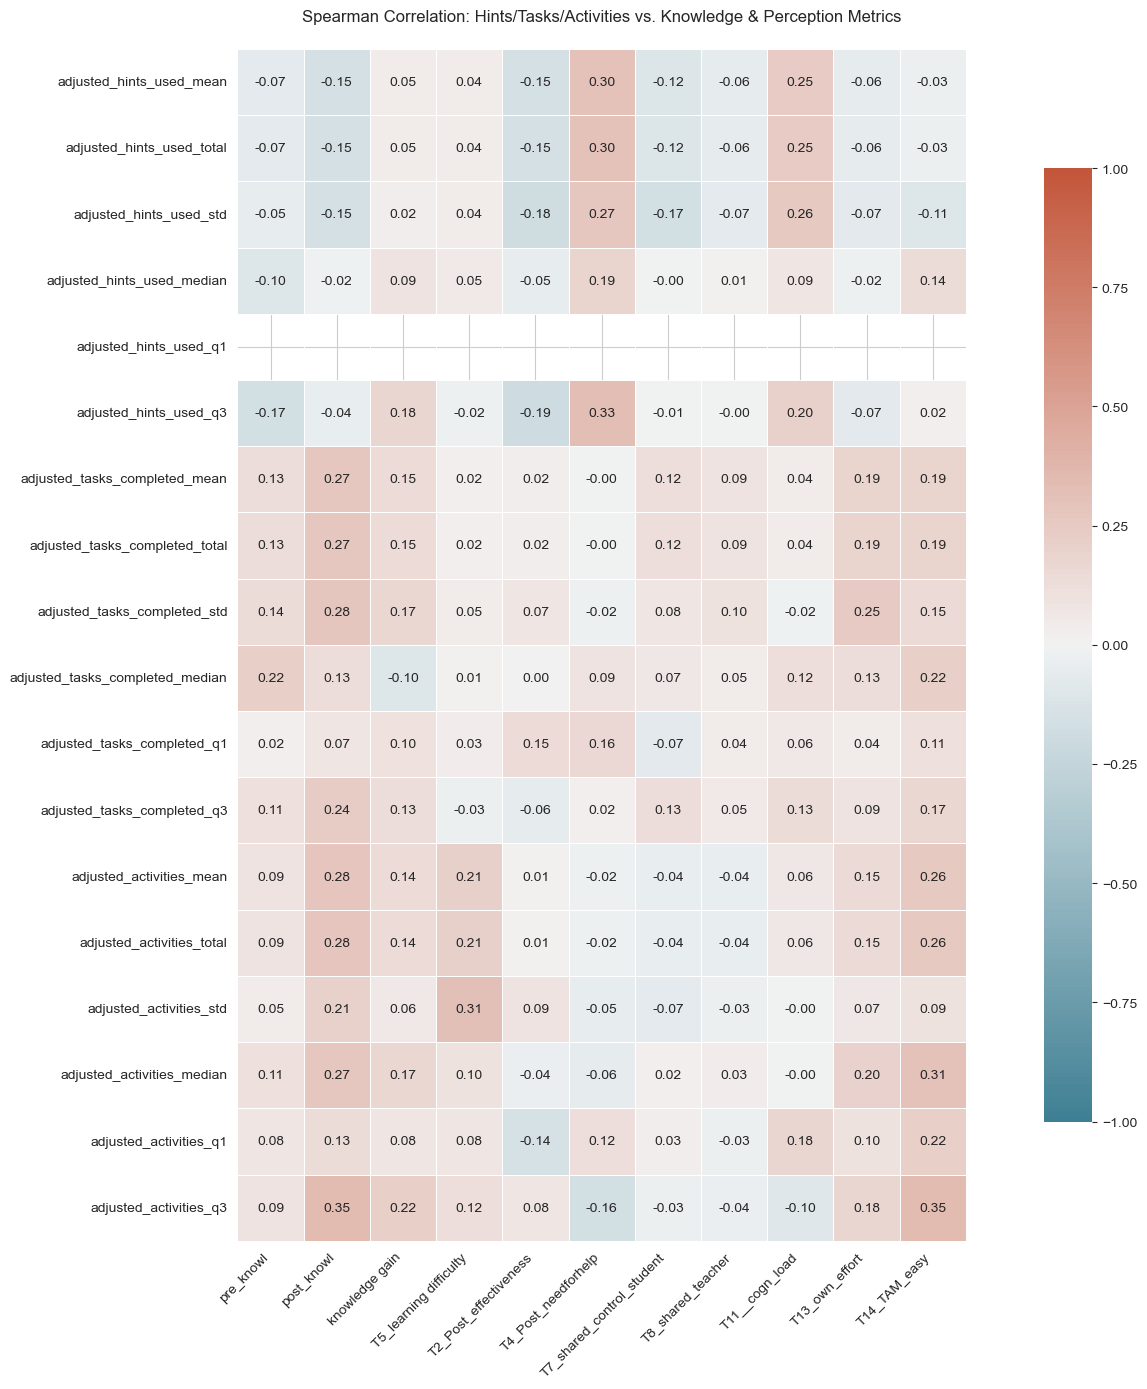

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


group1 = df_ep.columns.to_list()
group2 = df_kno.columns.to_list() + df_sel.columns.to_list()

# 1. Compute correlation matrix
corr_method = 'spearman'  
corr_matrix = clean_df.corr(method=corr_method)

# 2. Filter for cross-group correlations only
cross_corr = corr_matrix.loc[group1, group2]

# 3. Visualization
plt.figure(figsize=(16, 14))

# Create custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True, center='light')

# Heatmap with annotations
ax = sns.heatmap(
    cross_corr,
    vmin=-1, vmax=1, center=0,
    cmap=cmap,
    square=True,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cbar_kws={'shrink': 0.8}
)

# Improve readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title(f'{corr_method.title()} Correlation: Hints/Tasks/Activities vs. Knowledge & Perception Metrics', pad=20)
plt.tight_layout()

# 4. Save and show
#plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Get top correlations (optional)
corr_stack = cross_corr.stack().reset_index()
corr_stack.columns = ['Group1', 'Group2', 'Correlation']
top_pos = corr_stack.sort_values('Correlation', ascending=False).head(5)
top_neg = corr_stack.sort_values('Correlation').head(5)


## Top Correlations

### Positive Correlations

| Rank | Group1 Feature               | Group2 Feature            | Correlation |
|------|------------------------------|---------------------------|-------------|
| 1    | adjusted_activities_q3       | T14_TAM_easy              | 0.35        |
| 2    | adjusted_activities_q3       | post_knowl                | 0.35        |
| 3    | adjusted_hints_used_q3       | T4_Post_needforhelp       | 0.33        |
| 4    | adjusted_activities_std      | T5_learning difficulty    | 0.31        |
| 5    | adjusted_activities_median   | T14_TAM_easy              | 0.31        |

### Negative Correlations

| Rank | Group1 Feature               | Group2 Feature            | Correlation |
|------|------------------------------|---------------------------|-------------|
| 1    | adjusted_hints_used_q3       | T2_Post_effectiveness     | -0.19       |
| 2    | adjusted_hints_used_std      | T2_Post_effectiveness     | -0.18       |
| 3    | adjusted_hints_used_q3       | pre_knowl                 | -0.17       |
| 4    | adjusted_hints_used_std      | T7_shared_control_student | -0.17       |
| 5    | adjusted_activities_q3       | T4_Post_needforhelp       | -0.16       |

In [126]:
top_neg

,Group1,Group2,Correlation
48,adjusted_hints_used_q3,T2_Post_effectiveness,-0.189838
26,adjusted_hints_used_std,T2_Post_effectiveness,-0.181353
44,adjusted_hints_used_q3,pre_knowl,-0.165779
28,adjusted_hints_used_std,T7_shared_control_student,-0.165341
181,adjusted_activities_q3,T4_Post_needforhelp,-0.164228


# Clustering


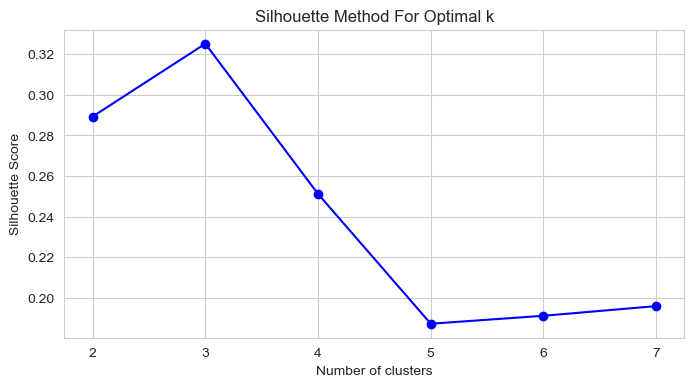

Optimal number of clusters: 3

Cluster Statistics:
cluster                                     0             1             2
adjusted_hints_used_mean         5.666688e+06  1.092188e+05  2.525423e+05
adjusted_hints_used_total        6.800025e+07  1.310626e+06  3.030507e+06
adjusted_hints_used_std          1.962990e+07  3.783291e+05  8.747925e+05
adjusted_hints_used_min          0.000000e+00  0.000000e+00  0.000000e+00
adjusted_hints_used_max          6.800000e+07  1.310565e+06  3.030366e+06
adjusted_hints_used_median       1.734036e+01  6.520765e-01  7.976334e+00
adjusted_hints_used_q1           0.000000e+00  0.000000e+00  0.000000e+00
adjusted_hints_used_q3           4.133652e+01  1.048481e+01  2.436059e+01
adjusted_tasks_completed_mean    6.263488e+01  5.415271e+01  8.784169e+01
adjusted_tasks_completed_total   8.768883e+02  7.581380e+02  1.229784e+03
adjusted_tasks_completed_std     4.692913e+01  4.154822e+01  5.499362e+01
adjusted_tasks_completed_min     0.000000e+00  1.602564e-01  

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

# Assuming df is your DataFrame with Group 1 features
group1_features = [
    'adjusted_hints_used_mean', 'adjusted_hints_used_total',
    'adjusted_hints_used_std', 'adjusted_hints_used_min',
    'adjusted_hints_used_max', 'adjusted_hints_used_median',
    'adjusted_hints_used_q1', 'adjusted_hints_used_q3',
    'adjusted_tasks_completed_mean', 'adjusted_tasks_completed_total',
    'adjusted_tasks_completed_std', 'adjusted_tasks_completed_min',
    'adjusted_tasks_completed_max', 'adjusted_tasks_completed_median',
    'adjusted_tasks_completed_q1', 'adjusted_tasks_completed_q3',
    'adjusted_activities_mean', 'adjusted_activities_total',
    'adjusted_activities_std', 'adjusted_activities_min',
    'adjusted_activities_max', 'adjusted_activities_median',
    'adjusted_activities_q1', 'adjusted_activities_q3'
]

# 1. Preprocess data
X = clean_df[group1_features].copy()

# Handle missing values if any
X = X.dropna()

# Standard scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 2. Determine optimal number of clusters using Silhouette method
silhouette_scores = []
k_range = range(2, 8)  # Testing cluster numbers from 2 to 7

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.grid(True)
plt.show()

# Select optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# 3. Perform K-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
clean_df['cluster'] = cluster_labels





# 6. Cluster statistics summary
cluster_stats = clean_df.groupby('cluster')[group1_features].mean().T
print("\nCluster Statistics:")
print(cluster_stats)

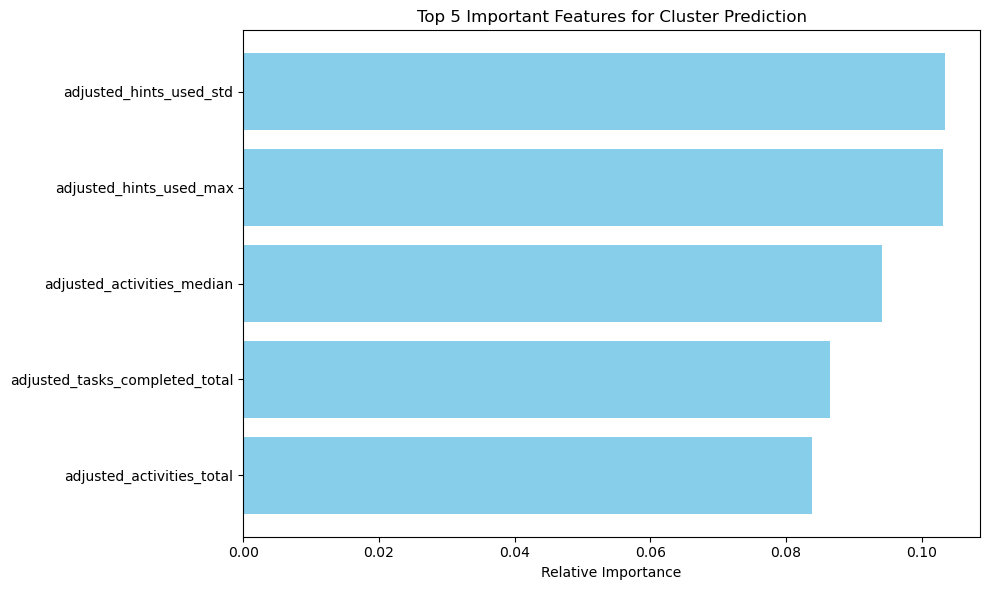

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare data
X = clean_df[group1_features].copy()
y = clean_df['cluster'].copy()

# Handle missing values if any
X = X.dropna()
y = y.loc[X.index]

# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[-5:]  # Top 5 features
features = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title('Top 5 Important Features for Cluster Prediction')
plt.barh(range(5), importances[indices], align='center', color='skyblue')
plt.yticks(range(5), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

# 7. Create a DataFrame of feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)


In [78]:
print(importance_df.head(5).to_string(index=False))

                       Feature  Importance
       adjusted_hints_used_std    0.103444
       adjusted_hints_used_max    0.103151
    adjusted_activities_median    0.094105
adjusted_tasks_completed_total    0.086494
     adjusted_activities_total    0.083871


/var/folders/yz/d_7lkc5d3136jv69fndfsmfm0000gn/T/ipykernel_15597/167649981.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/yz/d_7lkc5d3136jv69fndfsmfm0000gn/T/ipykernel_15597/167649981.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


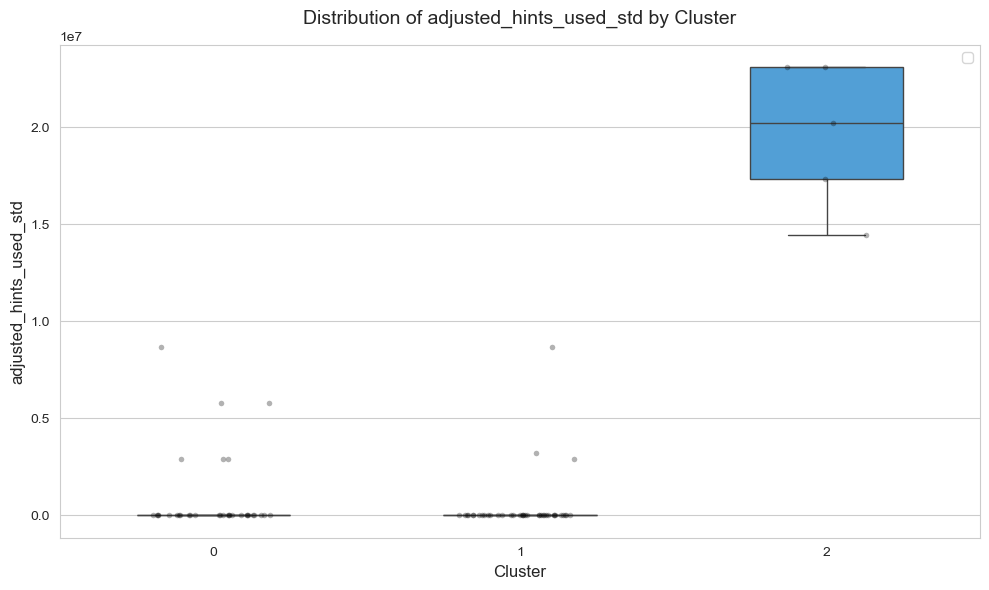


Statistics for adjusted_hints_used_std:
         count          mean           std           min           25%           50%           75%           max
cluster                                                                                                         
0         33.0  8.747925e+05  2.102177e+06  0.000000e+00  1.468198e+01  3.101263e+01  3.740463e+01  8.660247e+06
1         39.0  3.783291e+05  1.522092e+06  3.207181e+00  1.139176e+01  1.573048e+01  2.953202e+01  8.660250e+06
2          5.0  1.962990e+07  3.763864e+06  1.443375e+07  1.732050e+07  2.020725e+07  2.309400e+07  2.309401e+07


/var/folders/yz/d_7lkc5d3136jv69fndfsmfm0000gn/T/ipykernel_15597/167649981.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


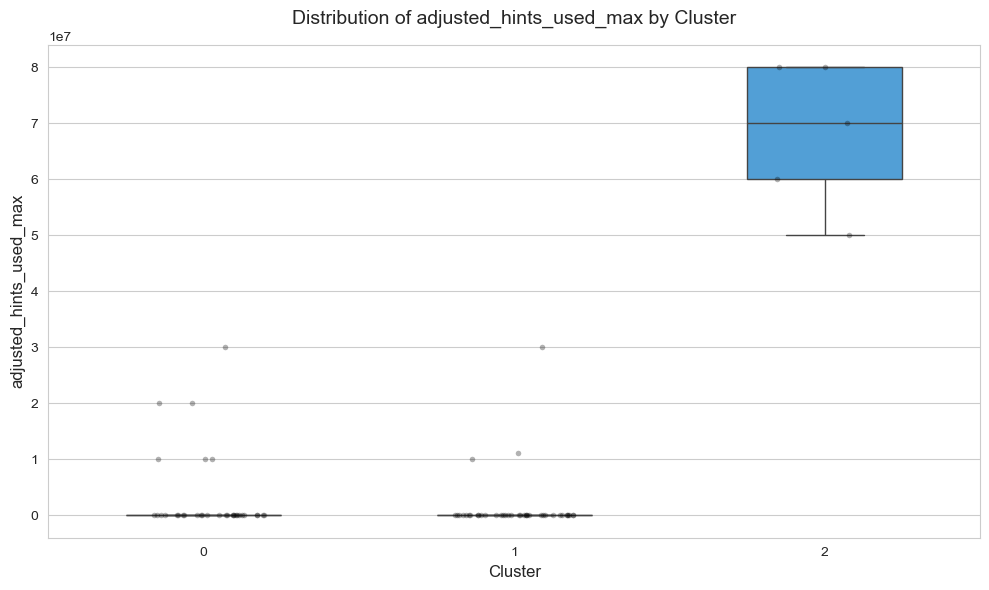


Statistics for adjusted_hints_used_max:
         count          mean           std          min           25%         50%         75%         max
cluster                                                                                                  
0         33.0  3.030366e+06  7.282164e+06         0.00  4.444667e+01       100.0       100.0  30000000.0
1         39.0  1.310565e+06  5.272686e+06        11.11  3.333000e+01        50.0       100.0  30000000.0
2          5.0  6.800000e+07  1.303840e+07  50000000.00  6.000000e+07  70000000.0  80000000.0  80000000.0


/var/folders/yz/d_7lkc5d3136jv69fndfsmfm0000gn/T/ipykernel_15597/167649981.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


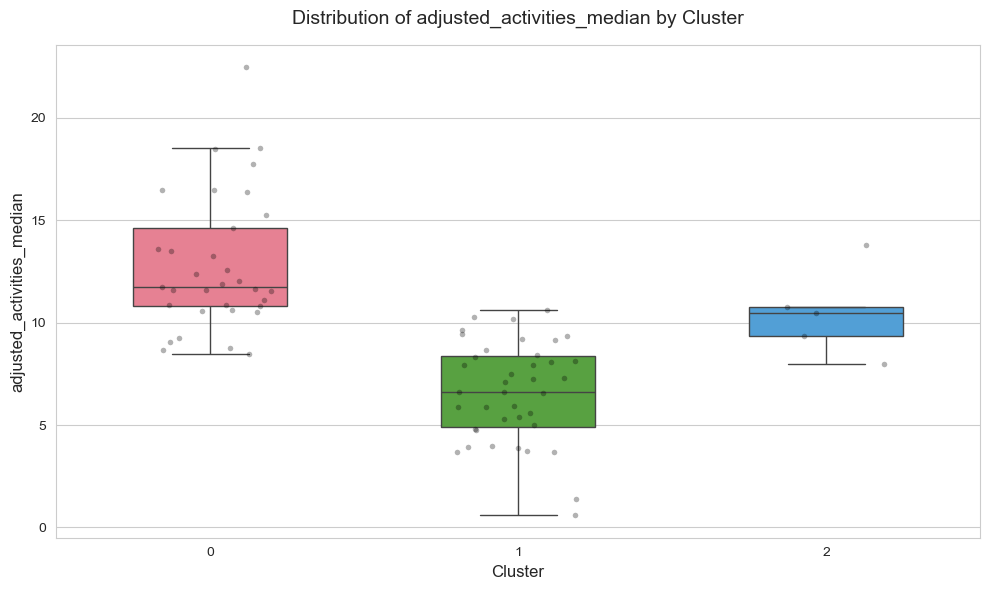


Statistics for adjusted_activities_median:
         count       mean       std       min        25%        50%        75%        max
cluster                                                                                  
0         33.0  12.833599  3.307836  8.488889  10.800000  11.761905  14.645833  22.479167
1         39.0   6.612396  2.438183  0.590909   4.896329   6.602679   8.378125  10.625000
2          5.0  10.476329  2.169895  7.966667   9.350000  10.468750  10.776786  13.819444


/var/folders/yz/d_7lkc5d3136jv69fndfsmfm0000gn/T/ipykernel_15597/167649981.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


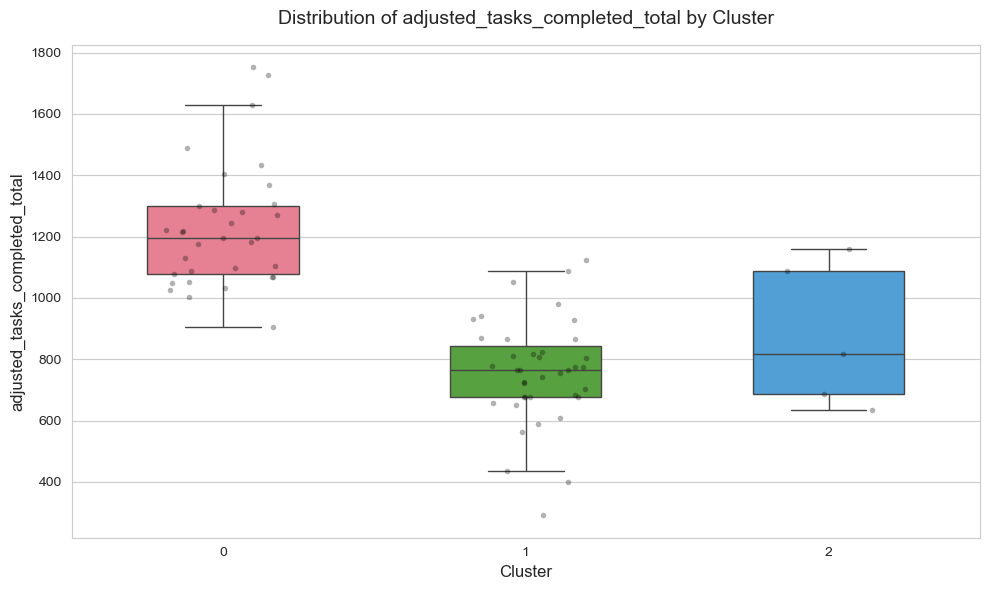


Statistics for adjusted_tasks_completed_total:
         count         mean         std       min         25%        50%         75%        max
cluster                                                                                        
0         33.0  1229.783691  201.973889  906.3723  1077.37970  1194.6869  1299.24570  1752.2525
1         39.0   758.137976  172.066113  290.8650   676.59495   765.2530   844.18225  1124.4869
2          5.0   876.888320  236.269734  632.8660   688.12300   816.2374  1086.89950  1160.3157


/var/folders/yz/d_7lkc5d3136jv69fndfsmfm0000gn/T/ipykernel_15597/167649981.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


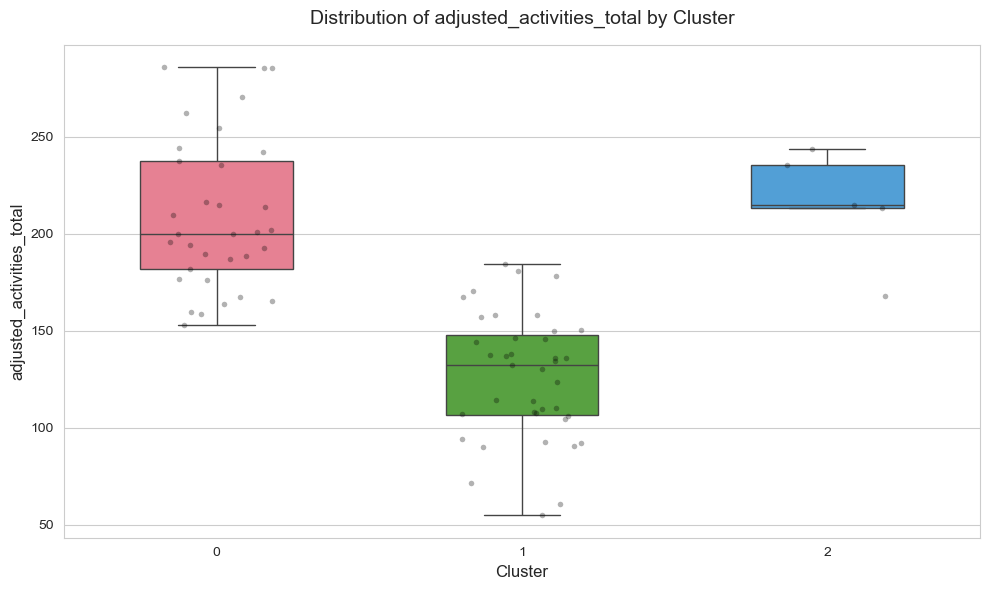


Statistics for adjusted_activities_total:
         count        mean        std         min         25%         50%         75%         max
cluster                                                                                          
0         33.0  209.369469  39.193563  152.812626  181.729563  199.992965  237.349260  285.749008
1         39.0  126.268791  32.259949   54.895310  106.670031  132.540639  148.026019  184.537410
2          5.0  214.920455  29.277261  167.992857  213.066108  214.917262  235.251046  243.375000


In [106]:
#| label: fig-cluster_dist
#| fig-cap: "Behavioral clusters"
#| fig-align: center
#| warning: false

# Set style
sns.set_style("whitegrid")
palette = sns.color_palette("husl", n_colors=len(clean_df['cluster'].unique()))  

# Features to plot
features = [
    'adjusted_hints_used_std',
    'adjusted_hints_used_max',
    'adjusted_activities_median',
    'adjusted_tasks_completed_total',
    'adjusted_activities_total'
]

for feature in features:
    plt.figure(figsize=(10, 6))
    
    # Box plot
    ax = sns.boxplot(
        x='cluster',
        y=feature,
        data=clean_df,
        palette=palette,
        width=0.5,
        showfliers=False  # Hide outliers for cleaner visualization
    )
    
    # Add data points
    sns.stripplot(
        x='cluster',
        y=feature,
        data=clean_df,
        color='black',
        alpha=0.3,
        size=4,
        jitter=0.2
    )
    
    # Add annotations
    plt.title(f'Distribution of {feature} by Cluster', fontsize=14, pad=15)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    

    # Add legend only once
    if feature == features[0]:
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nStatistics for {feature}:")
    print(clean_df.groupby('cluster')[feature].describe().to_string())

In [108]:
X_scaled

array([[-0.3628559 , -0.3628559 , -0.36285103, ...,  0.61679101,
         0.84004246,  0.14146324],
       [-0.36284756, -0.36284756, -0.36284681, ...,  1.67148937,
         1.9587736 ,  1.23473254],
       [-0.36284733, -0.36284733, -0.36284719, ..., -0.3887333 ,
         0.23072002, -0.77246464],
       ...,
       [-0.3628512 , -0.3628512 , -0.36285029, ...,  0.50352116,
         0.48681206,  0.3409179 ],
       [ 3.61947683,  3.61947683,  3.61947082, ...,  0.2293335 ,
         0.88777903,  0.23289926],
       [-0.36283853, -0.36283853, -0.36284685, ...,  0.90844393,
         1.36635576,  0.31770635]])